<a href="https://colab.research.google.com/github/noraleilaa/453/blob/main/A_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization.

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [ ]:
!python -m spacy download en_core_web_lg -q

2023-11-09 02:52:44.566743: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 02:52:44.566817: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 02:52:44.566863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 02:52:48.307415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#! ls -l /content/gdrive

### NLTK Downloads

In [ ]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [ ]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [ ]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [ ]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc):
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(in_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [ ]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')

def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')

    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)

    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')

def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []

    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()

        output.append(rows)
        sources = set(rows.target).union(set(rows.source))

    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))

    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)

    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)

    plt.show()

def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)

        # Matcher class object
        matcher = Matcher(nlp.vocab)

        #define the pattern
        pattern = [{'DEP':'ROOT'},
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},
                {'POS':'ADJ','OP':"?"}]
        matcher.add("matching_1", [pattern])
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]

        return(span.text)
    except:
        pass

def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [ ]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Loading the Class Corpus

In [ ]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [ ]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Tokenize Words

In [ ]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
90    [target, heavily, outnumber, outgunne, mike, b...
91    [sleepy, dopey, action, bonanza, angel, fall, ...
92    [angel, fall, mark, time, gerard, butler, secr...
93    [improve, blandness, mike, banning, gerard, bu...
94    [review, contain, spoiler, angel, fallen, movi...
Name: lemmas, dtype: object

In [ ]:
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Reassemble Leminized Words

In [ ]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [ ]:
corpus_df['lemmas_joined'].head()

Doc_ID
90    target heavily outnumber outgunne mike banning...
91    sleepy dopey action bonanza angel fall disappo...
92    angel fall mark time gerard butler secret serv...
93    improve blandness mike banning gerard butler w...
94    review contain spoiler angel fallen movie extr...
Name: lemmas_joined, dtype: object

In [ ]:
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Vocabulary Data Wrangling

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 8802
Curated Vocabulary size: 1774


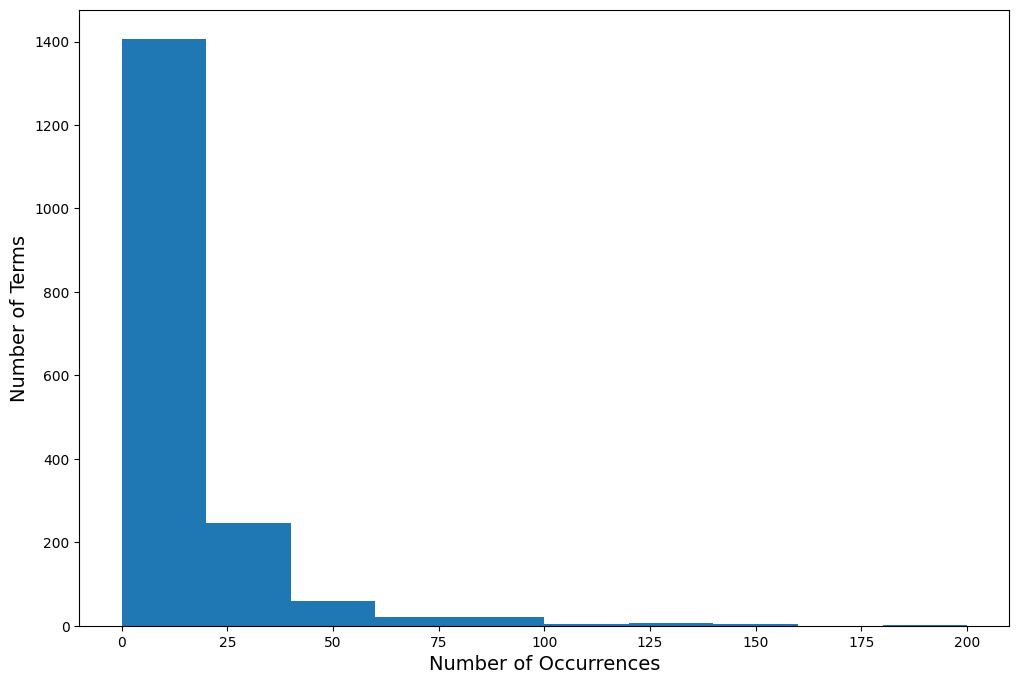

In [ ]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences',fontsize=14)
plt.ylabel('Number of Terms',fontsize=14);

In [ ]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
90    [target, heavily, mike, banning, gerard, butle...
91    [action, angel, fall, reason, expect, second, ...
92    [angel, fall, mark, time, gerard, butler, secr...
93    [mike, banning, gerard, butler, accept, promot...
94    [review, contain, spoiler, angel, fallen, movi...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words

In [ ]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [ ]:
corpus_df.head().T

Doc_ID,90,91,92,93,94
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen,LKP_Doc5_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...,Improving through blandness . So Mike Banning ...,This review may contain spoilers . Angel Has F...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen,LKP_Doc5_Angel_has_fallen
Student Name,LKP,LKP,LKP,LKP,LKP
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92,Action_Angel_has_fallen_N_93,Action_Angel_has_fallen_N_94
Doc_ID,90,91,92,93,94
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...,"[Improving through blandness ., So Mike Bannin...","[This review may contain spoilers ., Angel Has..."


## Review Documents By Movie Title

In [ ]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


In [ ]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Mean_Girls'].copy()
# or
#movie_df = corpus_df[corpus_df['Movie Title'] == 'Dirty_Grandpa'].copy()
movie_df.head(3).T

Doc_ID,1,2,3
DSI_Title,XOY_Doc2_Mean_Girls,XOY_Doc3_Mean_Girls,XOY_Doc4_Mean_Girls
Text,Although Mean Girls is likely to be frequently...,She is immediately befriended by two of North ...,Mean Girls '' is somewhat of a phenomenon in t...
Submission File Name,XOY_Doc2_Mean_Girls,XOY_Doc3_Mean_Girls,XOY_Doc4_Mean_Girls
Student Name,XOY,XOY,XOY
Genre of Movie,Comedy,Comedy,Comedy
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Mean_Girls,Mean_Girls,Mean_Girls
Descriptor,Comedy_Mean_Girls_N_1,Comedy_Mean_Girls_N_2,Comedy_Mean_Girls_N_3
Doc_ID,1,2,3
raw_sentences,[Although Mean Girls is likely to be frequentl...,[She is immediately befriended by two of North...,[Mean Girls '' is somewhat of a phenomenon in ...


## Knowledge Graph Extraction

In [ ]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

"There 's a clique for almost every type of student - even the loners have their exclusive group ."

In [ ]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 184/184 [00:01<00:00, 93.69it/s] 


In [ ]:
entity_pairs

[['it', 'strongly  me'],
 ['Mean  Girls', 'comic closing credits roll'],
 ['happy  screenplay', 'unsettling  denouement'],
 ['then  it', 'finish line'],
 ['other  you', 'friends'],
 ['even  loners', 'exclusive  group'],
 ['you', 'lunchroom'],
 ['chess they', 'social  plague'],
 ['it', 'what'],
 ['what', 'power'],
 ['old Linday who', 'first  time'],
 ['all  Cady', 'suburban peer pressure'],
 ['only  one', 'her'],
 ['two  couple', 'her'],
 ['Lizzy other', ''],
 ['where  Cady', 'life'],
 ['unexpectedly  Cady', 'three  plastics'],
 ['leader', ''],
 ['gregarious Lizzy teddy', 'Damian'],
 ['ostracized  three', 'them'],
 ['it', 'powerful  position'],
 ['Cady', 'social  standing'],
 ['stalwarts Gretchen Weiners', 'Plastics'],
 ['Cady', 'perfect  makeup'],
 ['it', 'social food chain'],
 ['new director Mark it', 'nasty  2004'],
 ['Other Saturday Night Live', 'supremely screenplay insight'],
 ['penned CIA spy teenagers', 'craven  minutiae'],
 ['I', 'high  school'],
 ['I', 'one  group'],
 ['I', 'l

### Create DataFrame (Source, Target, Edge)

In [ ]:
relations = [get_relation(x) for x in corpus_text_sentences]
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [ ]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [ ]:
kg_df.head(6).T

,0,1,2,3,4,5
source,it,mean girls,happy screenplay,then it,other you,even loners
target,strongly me,comic closing credits roll,unsettling denouement,finish line,friends,exclusive group
edge,is,offer,is,works for,judged by,have


In [ ]:
kg_df.shape

(157, 3)

In [ ]:
len(corpus_text_sentences)

184

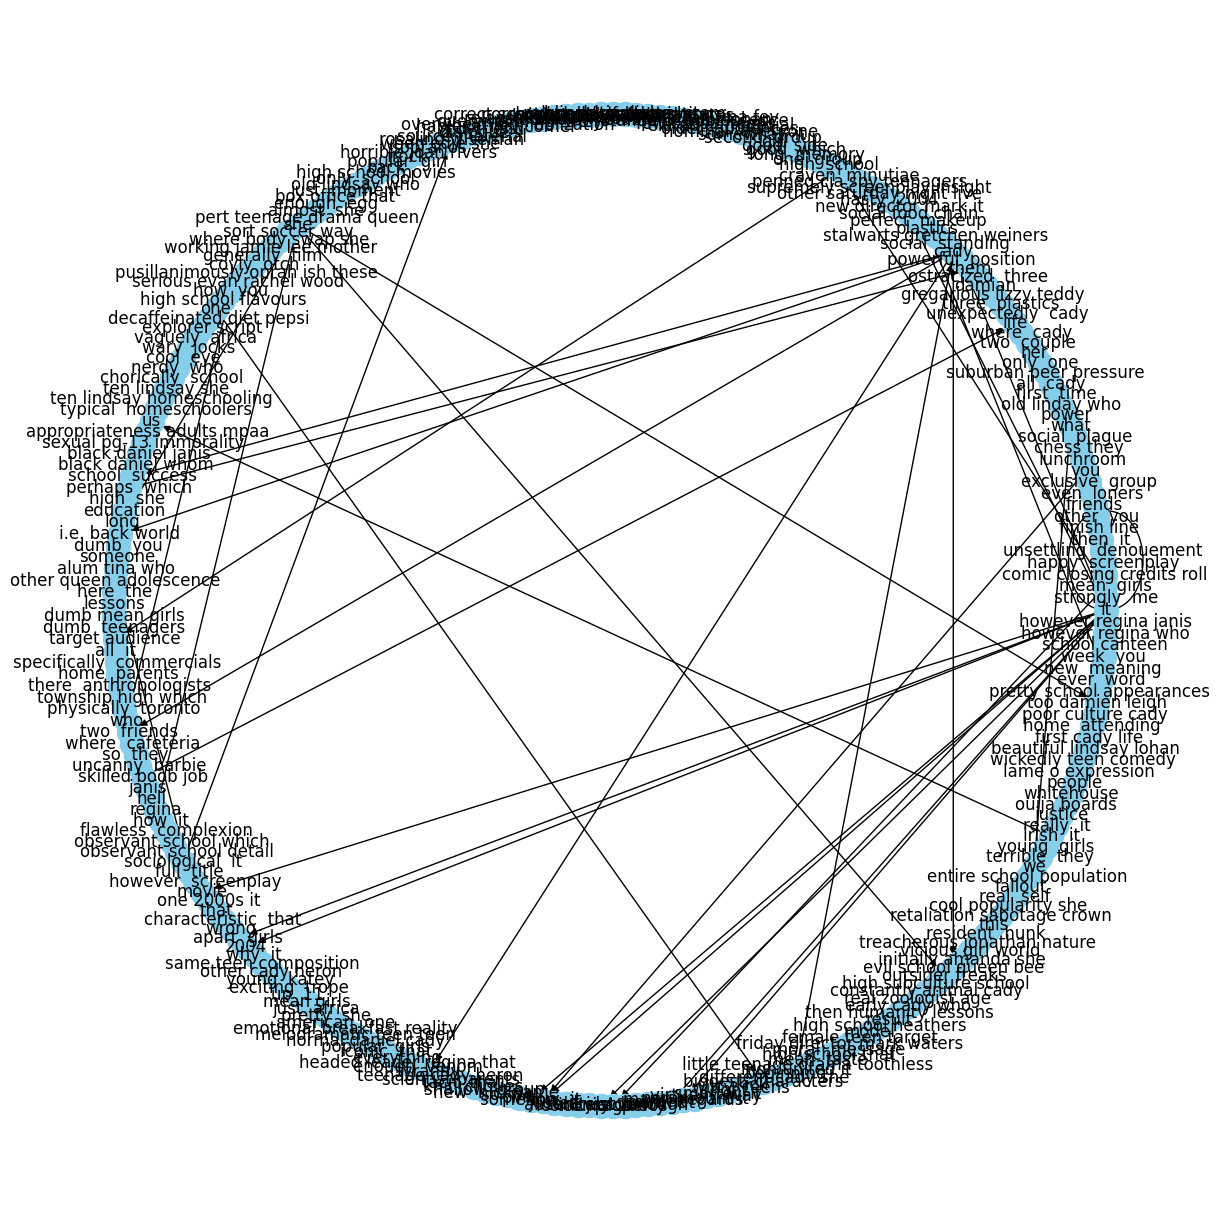

In [ ]:
plot_graph(kg_df, use_circular=True)

##BEGIN EXPERIMENTAL CODE


In [ ]:
# I sometimes export the knowledge data-frames to Excel. I have found it useful to examine the results
# and hand edit the results and import them back for the semi-automated construction of the knowledge graph.

In [ ]:
# kg_df.to_excel("kg.xlsx")

OpenAI extracts Entities

In [ ]:
# If you want to try it, you'll need an account with OpenAI to use this experimental code.
# I spent under a dollar working on it as it's not expensive, but watch your spending, and set limit!
# Remember, the OpenAI API isn't free!
#
# Get API Key here:   https://platform.openai.com/account/api-keys
# Monitor usage:      https://platform.openai.com/account/usage
# Set usage limits:   https://platform.openai.com/account/billing/limits
#
# (Put your OpenAI key in the function parse_sentences_openai( ) .)
# I developed it in the starter code notebook and removed the extraneous cells so you can see what's new.

# There's basically two functions
#   (1) parse_sentences_openai( ) which makes the OpenAI API calls
#   (2) parse_openai_response( ) which takes the OpenAI API output and tries to put them
#         into a knowledge graph data-frame called global_kg_df2 .

In [ ]:
#!pip install openai

In [ ]:
# import nltk
# import pandas as pd
# import re
# #from nltk.tokenize import sent_tokenize
# import re
# from io import StringIO
# import openai
# import time

# nltk.download('punkt')

# def parse_openai_response(response):
#     print ("Response: ", response, "\n")
#     try:  # Parsing might blow up
#       # Check the style of the output and parse accordingly
#       if "Subject: " in response and "Verb: " in response and "Object: " in response:
#           if " - " in response:
#               chunks = response.strip().split("\n\n")
#               subjects, verbs, objects = [], [], []
#               for chunk in chunks:
#                   subject = re.search('Subject: (.*)', chunk)
#                   verb = re.search('Verb: (.*)', chunk)
#                   obj = re.search('Object: (.*)', chunk)
#                   if subject: subjects.append(subject.group(1).strip())
#                   if verb: verbs.append(verb.group(1).strip())
#                   if obj: objects.append(obj.group(1).strip())
#           else:
#               lines = response.strip().split("\n")
#               subjects, verbs, objects = [], [], []
#               for line in lines:
#                   subject = re.search('Subject: (.*?);', line)
#                   verb = re.search('Verb: (.*?);', line)
#                   obj = re.search('Object: (.*)', line)
#                   if subject: subjects.append(subject.group(1))
#                   if verb: verbs.append(verb.group(1))
#                   if obj: objects.append(obj.group(1))
#       elif "(" in response and ")" in response:
#           lines = response.strip().split("\n")
#           subjects, verbs, objects = [], [], []
#           for line in lines:
#               match = re.search('\((.*); (.*); (.*)\)', line)
#               if match:
#                   subjects.append(match.group(1).strip())
#                   verbs.append(match.group(2).strip())
#                   objects.append(match.group(3).strip())
#       elif ";" in response:
#           # Remove the leading numbers and period from each line
#           response = re.sub(r'\d+\.', '', response)

#           # Use StringIO to convert the string to a file-like object for use with pandas
#           data = StringIO(response)

#           # Read the data into a pandas DataFrame, specifying the separator and column names
#           df = pd.read_csv(data, sep=';', names=['source', 'edge', 'target'])

#           # Strip leading/trailing whitespace from each cell in the DataFrame
#           df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
#           return df  # THERE ARE TWO RETURNS HERE. SHOULD CLEAN THIS UP IN THE FUTURE.

#       else:
#           subjects, verbs, objects = [], [], []
#           # raise ValueError("Unknown response format.")
#     except:
#       print ("Parsing ran into an error. Recovering.")
#       subjects, verbs, objects = [], [], []

#     try:
#       return_df= pd.DataFrame({'source': subjects, 'edge': verbs, 'target': objects})
#     except:
#       subjects, verbs, objects = [], [], []
#       return_df= pd.DataFrame({'source': subjects, 'edge': verbs, 'target': objects})

#     #return pd.DataFrame({'subject': subjects, 'verb': verbs, 'object': objects})
#     return return_df  # THERE ARE TWO RETURNS HERE. SHOULD CLEAN THIS UP IN THE FUTURE.


# def parse_sentences_openai(sentences, restart=0):
#     global global_kg_df2  # Use the global DataFrame

#     openai.api_key = 'PUT_IN_YOUR_OWN_OPENAI_KEY_HERE'
#     for i in range(restart, len(sentences)):
#         sentence = sentences[i]
#         print(f"Processing sentence {i}: {sentence}\n")
#         messages = [
#             {"role": "system", "content": "You are a helpful assistant that can extract separate tuples from English sentences of any complexity. The tuple should be in the form of (Subject; Verb; Object). Don't number the tuples. Dereference pronouns."},
#             {"role": "user", "content": sentence}
#         ]
#         response = openai.ChatCompletion.create(
#             model="gpt-3.5-turbo",
#             max_tokens=300,
#             temperature=0,
#             messages=messages
#         )
#         sentence_df = parse_openai_response(response['choices'][0]['message']['content'])
#         global_kg_df2 = global_kg_df2.append(sentence_df, ignore_index=True)
#         print ("From this sentence: ", len(sentence_df.index))
#         print ("Running total: ", len(global_kg_df2.index), "\n")
#         if (len(sentence_df.index)==0):
#             print ("NOTHING PARSED!")
#         time.sleep(10)   # I added a delay to avoid overwhelming the OpenAI servers. After I launched
#                          # this OpenAI code, I would do some chores and check back if it completed
#                          # or died. A 10 second delay may be excessive, so feel free to adjust
#                          # accordingly to your tastes and risk tolerance.
#     return global_kg_df2




In [ ]:
# # Define a global DataFrame
# global_kg_df2 = pd.DataFrame(columns=['source', 'edge', 'target'])


In [ ]:
# # If you want to experiment only at 5 sentences at first, you can specify a slice of the corpus_text_sentences array
# # like:
# #
# # parse_sentences_openai(corpus_text_sentences[:5],  0) # Work only on the first 5 sentences of the corpus

# # Once you feel comfortable with it and want to try to run it across the whole corpus, run it without a slice like:
# #

# parse_sentences_openai(corpus_text_sentences,  0) # Restart at sentence #0 or other sentence number, if you need to restart after OpenAI failure


# # In other words, I have found that the OpenAI calls sometimes fail or hang due to load and I need to restart the
# # parsing process again. I just look at the output to see what sentence it broke at.
# # Suppose it broke at sentence 30, then I can rerun parse_sentences_openai( ) with:
# #
# # parse_sentences_openai (corpus_text_sentences,  30)
# #
# # and it'll continue adding to the knowledge graph data-frame global_kg_df2 where it left off.

In [ ]:
# global_kg_df2.shape

In [ ]:
# For manual review or editing of the dataframes
#global_kg_df2.to_excel("kg2.xlsx")

In [ ]:
# print(global_kg_df2)

In [ ]:
# # Move everything to lower case
# global_kg_df2.source = global_kg_df2.source.str.lower()
# global_kg_df2.target = global_kg_df2.target.str.lower()
# global_kg_df2.edge = global_kg_df2.edge.str.lower()

# # Filter out empties
# global_kg_df2 = global_kg_df2[global_kg_df2.source != '']
# global_kg_df2 = global_kg_df2[global_kg_df2.target != '']
# global_kg_df2 = global_kg_df2[global_kg_df2.edge != ''].copy()

# # Filter out empties
# global_kg_df2 = global_kg_df2[global_kg_df2.source != 'NaN']
# global_kg_df2 = global_kg_df2[global_kg_df2.target != 'NaN']
# global_kg_df2 = global_kg_df2[global_kg_df2.edge != 'NaN'].copy()

In [ ]:
# print(global_kg_df2)

In [ ]:
# global_kg_df2.shape

In [ ]:
# plot_graph(global_kg_df2, use_circular=True)

END EXPERIMENTAL CODE

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [ ]:
datafull=corpus_df.copy()
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

,0,1,2,3
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...,Improving through blandness . So Mike Banning ...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen
Student Name,LKP,LKP,LKP,LKP
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92,Action_Angel_has_fallen_N_93
Doc_ID,90,91,92,93
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...,"[Improving through blandness ., So Mike Bannin..."


In [ ]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet

In [ ]:
data = datafull[['Text','Genre of Movie']].copy()

In [ ]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

## Review Examples by Genre

In [ ]:
features, targets = data['Text'], data['Genre of Movie code']
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      50
Comedy          1                      50
Horror          2                      50
Sci-Fi          3                      50
dtype: int64

## Create Datasets for Model Development

### Cell 10 - def get_dataset_partitions_pd

In [ ]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

## Convert DataFrame to TensorFlow DataSet

In [ ]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
)
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  )
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
)
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
)
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [ ]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [ ]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [ ]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'i', 'movie', 'nt', 'like', 'one',
       'it', 'time', 'character', 'even', 'get', 'also', 'make', 'two',
       'action', 'story'], dtype='<U19')

In [ ]:
vocab[-20:]

array(['thx1138', 'thwarting', 'thwarted', 'thursday', 'thunderbolt',
       'thug', 'thud', 'throwing', 'throwback', 'throwaway', 'through',
       'throe', 'throatclenching', 'thrives', 'thrive', 'threaten',
       'thrash', 'thowy', 'thousand', 'thoughtpoliceman'], dtype='<U19')

## Example of Encoded Words

In [ ]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  220, 1379,  492, 2225,    1,  104,  104])

In [ ]:
len(encoder.get_vocabulary())

5000

In [ ]:
encoder(data['Text'][0])

<tf.Tensor: shape=(276,), dtype=int64, numpy=
array([1045,  363,  855,    1,    1,  114,  187,  675,  421, 3154,    1,
          1,    1, 1238,    1,  493,    1,  462,  733,   25, 1224,  494,
          2,  941, 4223,    1,  441, 1561,  278,    2, 3479, 1660,  108,
       2206,   26,  380,  147,  578,    1, 3246,  279,  984,    2,  968,
         32,  282,   74,   79, 1033,  998,  187, 4309,  470,  325,   57,
        167,  376,  163, 1438,  713,  662,  616,   25,  207,   34,   24,
        231,  644, 1531,  163,  402, 3597,  114,    7,  629,    2, 1070,
        818,  697, 2118,  336,  524,  320, 2920, 3446, 1936,    1, 2633,
          7,  160,  260,  688,   96,  330, 3647, 2468, 2480,    1,   88,
          1,   20,  377, 1429,  202,    1,  933,  956, 1304,   77, 1451,
       1599, 1677, 2005,  237, 1887, 1934, 4117, 4151,  234,    1,    1,
         42,  269,  187,    2,    1,    1, 3058, 1151,  332, 2121, 4067,
       3044, 3155,  909,  521,   34, 3504, 1987, 4131,  162,   59, 1667,
     

In [ ]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b"Dirty Grandpa 11 % approval rating Rotten Tomatoes . It nominated five Golden Raspberries almost immaculate attendance record critic ' worst year list . Those reviewed pain point filthy found experience . Mark Kermode needed shower , Mike Ryan wanted burn print Glenn McDonald likened torture porn . For , chart-topping god-awfulness n't confined 2016 . Deadline 's Pete Hammond called worst movie Robert De Niro `` worst movie anyone ever `` . Reader , I liked . I liked time , watching last night , I liked even . It n't . Dirty Grandpa 's CinemaScore ass opening night audience reaction scale A ( excellent ) F ( frightful ) B . That 's worse Joker ( B+ ) improvement Little Fockers ( B- ) . These , perhaps , revealing comparison . For really condemned Dirty Grandpa eye critic position fag-end De Niro 's decade horriblis : prolific run rubbish dotted enough class remind time dropped trouser . In particular , Dirty Grandpa came wake Last Vegas The Intern : laughless horror-shows no

## Build RNN Sequential Model

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [ ]:
k.clear_session()
num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')
])

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 47s 570ms/step - loss: 1.3886 - accuracy: 0.2453 - val_loss: 1.3988 - val_accuracy: 0.3333
Epoch 2/200
53/53 [==============================] - 25s 462ms/step - loss: 1.1208 - accuracy: 0.5535 - val_loss: 1.2119 - val_accuracy: 0.4444
Epoch 3/200
53/53 [==============================] - 25s 464ms/step - loss: 0.3667 - accuracy: 0.8742 - val_loss: 1.9489 - val_accuracy: 0.2222
Epoch 4/200
53/53 [==============================] - 25s 465ms/step - loss: 0.1309 - accuracy: 0.9748 - val_loss: 2.5028 - val_accuracy: 0.4444
CPU times: user 3min 17s, sys: 750 ms, total: 3min 18s
Wall time: 2min 26s


## Model Performance Test Accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 70ms/step - loss: 1.2138 - accuracy: 0.6667
Test Loss: 1.2137528657913208
Test Accuracy: 0.6666666865348816


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,1.389,0.245,1.399,0.333
1,1.121,0.553,1.212,0.444
2,0.367,0.874,1.949,0.222
3,0.131,0.975,2.503,0.444


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

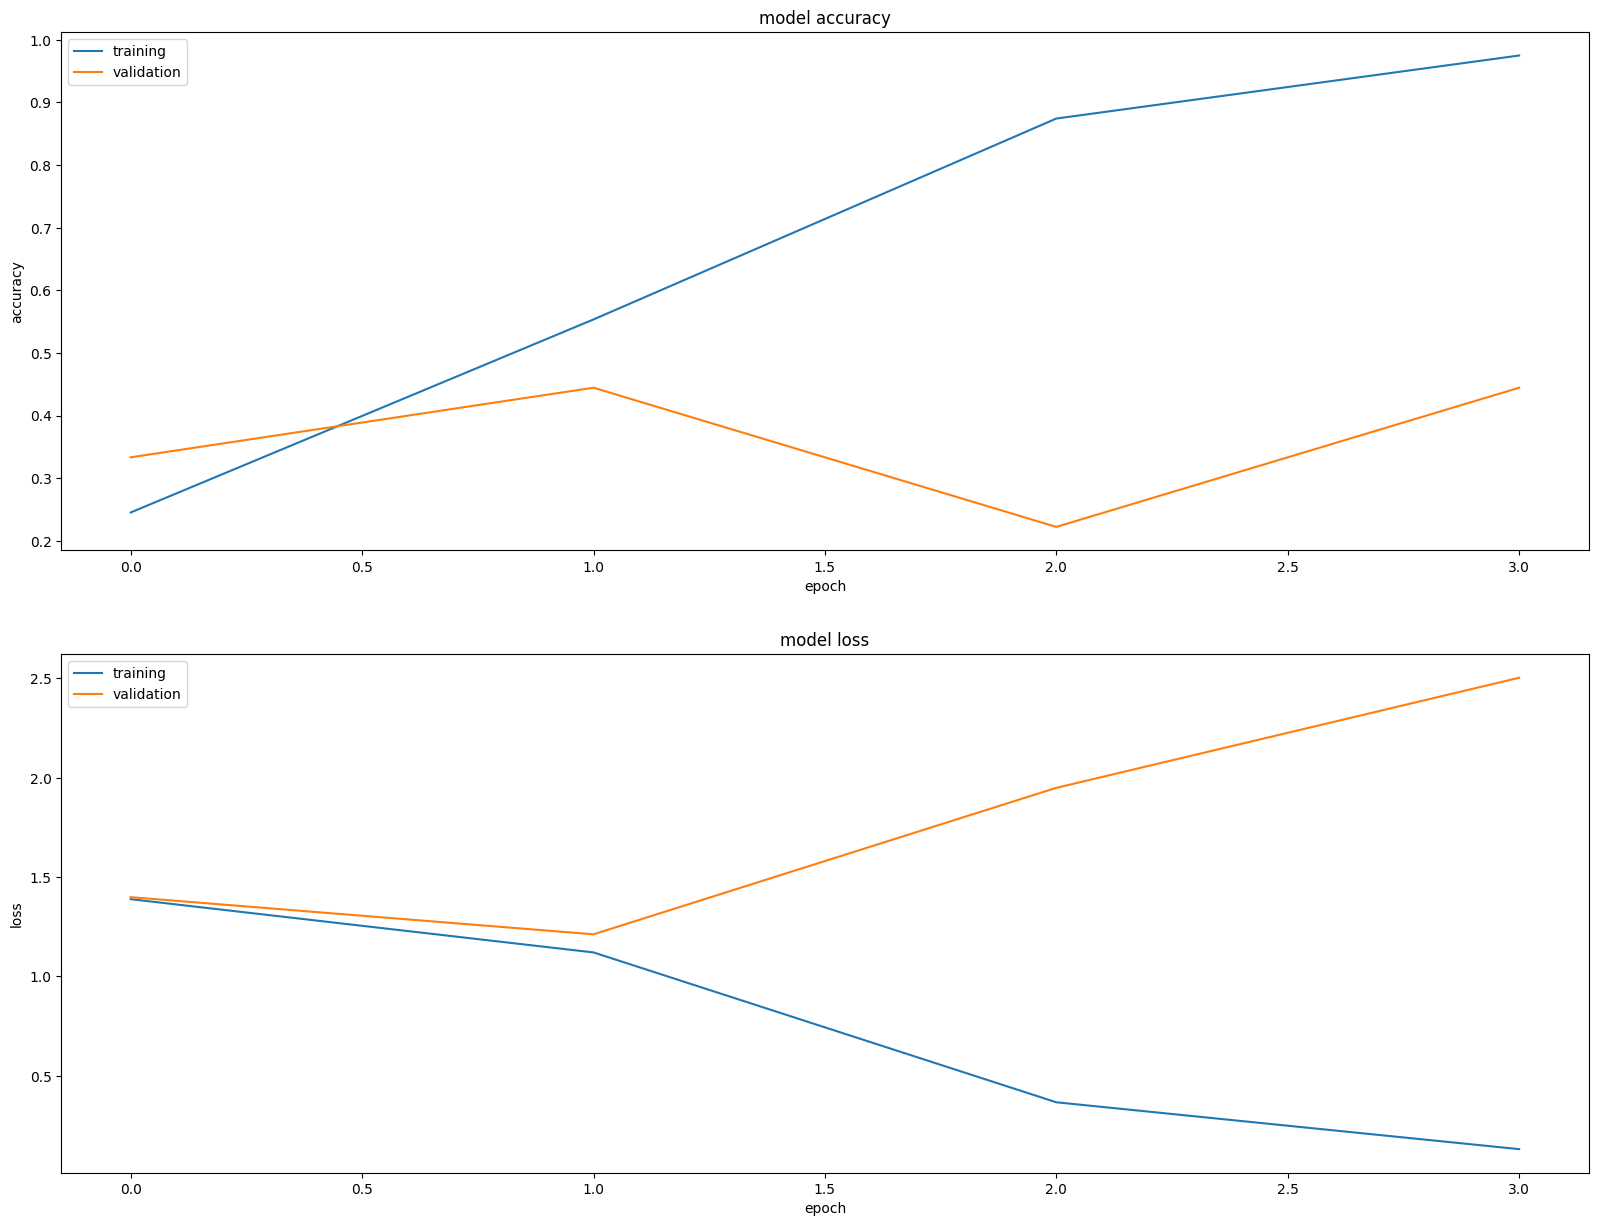

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Confusion Matrix Post Model Performance Analysis

In [ ]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 5s 69ms/step


In [ ]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

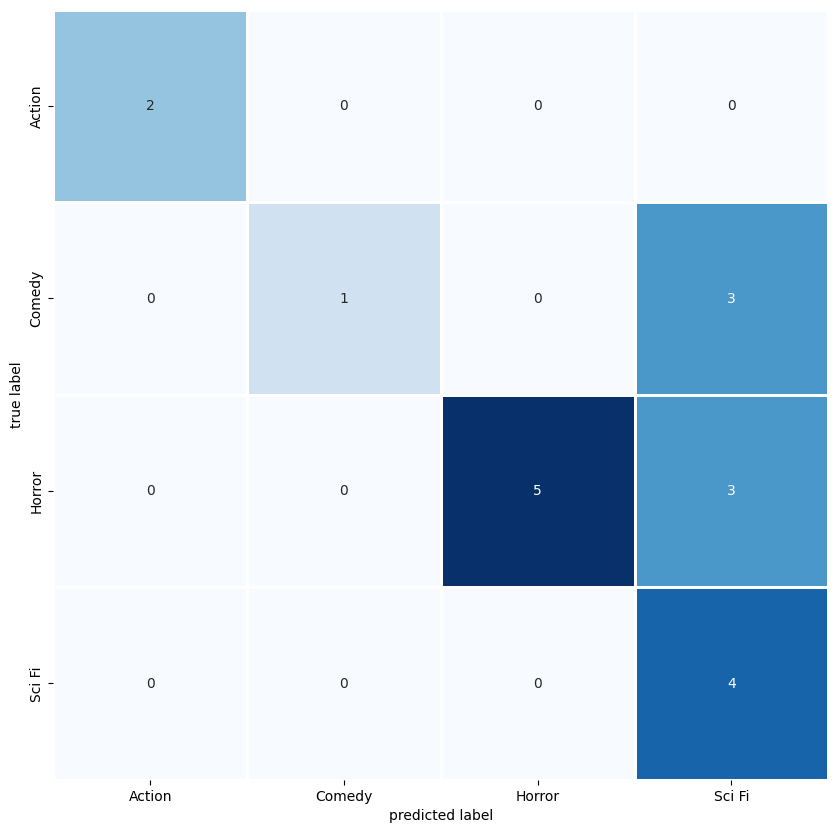

In [ ]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,0.46%,0.15%,0.72%,0.04%,0.70%,0.44%,8.03%,0.37%,0.59%,63.39%,0.03%,2.11%,0.31%,0.16%,1.31%
Comedy,2.29%,0.56%,1.03%,0.01%,1.55%,0.14%,88.78%,0.54%,0.22%,5.29%,0.01%,0.34%,0.91%,0.60%,4.04%
Horror,0.99%,1.14%,5.08%,99.49%,2.08%,98.12%,0.15%,13.67%,95.05%,17.64%,99.46%,96.50%,1.46%,1.38%,1.47%
Sci Fi,96.26%,98.16%,93.17%,0.46%,95.67%,1.30%,3.03%,85.41%,4.14%,13.68%,0.50%,1.05%,97.32%,97.85%,93.18%


## RNN Model Architecture

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

# Part 1 knowledge graphs

In [ ]:
spacy.explain('agent')

'agent'

In [ ]:
 MOVIE_TO_EXPLORE = 'Mean_Girls'

In [ ]:
movie_reviews = (corpus_df.loc[corpus_df['Movie Title'] == MOVIE_TO_EXPLORE, 'Text']
                             .reset_index(drop=True))

In [ ]:
movie_reviews

0    Although Mean Girls is likely to be frequently...
1    She is immediately befriended by two of North ...
2    Mean Girls '' is somewhat of a phenomenon in t...
3    The tagline for this movie - Watch Your Back -...
4    When 16-year-old Cady ( Lindsay Lohan ) first ...
5    `` In a wasteland of dumb movies about teenage...
6    Mean Girls looks and feels like a 2000s comedy...
7    Teenage Cady Heron ( Lindsay Lohan ) was educa...
8    Fans who found teen star Lindsay Lohan 's last...
9    'Gretchen , stop trying to make 'fetch ' happe...
Name: Text, dtype: object

In [ ]:
movie_reviews[1]

"She is immediately befriended by two of North Shore High 's friendlier social outcasts , the good-natured goth Janis ( Lizzy Caplan ) and gregarious teddy bear Damian ( Daniel Franzese ) . Cady finds kinship with the ostracized duo , the three of them quickly becoming best friends . But the newbie 's potent combination of beauty and brains also catches the eye of Regina George ( Rachel McAdams ) , the school 's cool and calculating Queen Bee , and she realizes straight away this newcomer has what it takes to usurp her powerful position . At the urging of Janis and Damian , Cady decides to fight fire with fire , insinuating herself within Regina 's clique of best friends , dubbed `` The Plastics , '' in order to conduct sabotage upon their collective social standing from within . Soon she appears to be every bit a member of The Plastics as stalwarts Gretchen Weiners ( Lacey Chabert ) and Karen Smith ( Amanda Seyfried ) are . Cady is strutting around the school wearing the latest fashio

In [ ]:
doc = nlp(movie_reviews[1])

In [ ]:
list(doc.sents)

[She is immediately befriended by two of North Shore High 's friendlier social outcasts , the good-natured goth Janis ( Lizzy Caplan ) and gregarious teddy bear Damian ( Daniel Franzese ) .,
 Cady finds kinship with the ostracized duo , the three of them quickly becoming best friends .,
 But the newbie 's potent combination of beauty and brains also catches the eye of Regina George ( Rachel McAdams ) , the school 's cool and calculating Queen Bee , and she realizes straight away this newcomer has what it takes to usurp her powerful position .,
 At the urging of Janis and Damian , Cady decides to fight fire with fire , insinuating herself within Regina 's clique of best friends , dubbed `` The Plastics , '' in order to conduct sabotage upon their collective social standing from within .,
 Soon she appears to be every bit a member of The Plastics as stalwarts Gretchen Weiners ( Lacey Chabert ) and Karen Smith ( Amanda Seyfried ) are .,
 Cady is strutting around the school wearing the lat

In [ ]:
doc_sents = [str(x) for x in list(doc.sents)]
doc_sents

["She is immediately befriended by two of North Shore High 's friendlier social outcasts , the good-natured goth Janis ( Lizzy Caplan ) and gregarious teddy bear Damian ( Daniel Franzese ) .",
 'Cady finds kinship with the ostracized duo , the three of them quickly becoming best friends .',
 "But the newbie 's potent combination of beauty and brains also catches the eye of Regina George ( Rachel McAdams ) , the school 's cool and calculating Queen Bee , and she realizes straight away this newcomer has what it takes to usurp her powerful position .",
 "At the urging of Janis and Damian , Cady decides to fight fire with fire , insinuating herself within Regina 's clique of best friends , dubbed `` The Plastics , '' in order to conduct sabotage upon their collective social standing from within .",
 'Soon she appears to be every bit a member of The Plastics as stalwarts Gretchen Weiners ( Lacey Chabert ) and Karen Smith ( Amanda Seyfried ) are .',
 'Cady is strutting around the school wear

In [ ]:
example_sent = doc_sents[0]
example_sent

"She is immediately befriended by two of North Shore High 's friendlier social outcasts , the good-natured goth Janis ( Lizzy Caplan ) and gregarious teddy bear Damian ( Daniel Franzese ) ."

In [ ]:
get_subject_verb_object(example_sent)

['teddy', 'befriended', 'Damian']

In [ ]:
example_nlp = nlp(example_sent)
example_nlp

She is immediately befriended by two of North Shore High 's friendlier social outcasts , the good-natured goth Janis ( Lizzy Caplan ) and gregarious teddy bear Damian ( Daniel Franzese ) .

In [ ]:
for tok in example_nlp:
    print(tok.dep_)

nsubjpass
auxpass
advmod
ROOT
agent
pobj
prep
compound
compound
poss
case
amod
amod
pobj
punct
det
amod
punct
amod
compound
dep
punct
compound
appos
punct
cc
amod
nsubj
conj
dobj
punct
compound
appos
punct
punct


In [ ]:
spacy.explain('punct')

'punctuation'

In [ ]:
get_entities(example_sent)


['gregarious Lizzy teddy', 'Damian']

In [ ]:
get_relation(example_sent)

'befriended by'

In [ ]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

entity_pairs

100%|██████████| 16/16 [00:00<00:00, 100.22it/s]


[['gregarious Lizzy teddy', 'Damian'],
 ['ostracized  three', 'them'],
 ['it', 'powerful  position'],
 ['Cady', 'social  standing'],
 ['stalwarts Gretchen Weiners', 'Plastics'],
 ['Cady', 'perfect  makeup'],
 ['it', 'social food chain'],
 ['new director Mark it', 'nasty  2004'],
 ['Other Saturday Night Live', 'supremely screenplay insight'],
 ['penned CIA spy teenagers', 'craven  minutiae'],
 ['I', 'high  school'],
 ['I', 'one  group'],
 ['I', 'long  memory'],
 ['good  which', 'good  side'],
 ['girl', 'second  group'],
 ['So  school', '']]

In [ ]:
relations = [get_relation(i) for i in tqdm(doc_sents)]
relations

100%|██████████| 16/16 [00:00<00:00, 97.09it/s]


['befriended by',
 'finds',
 'catches',
 'decides',
 'appears',
 'strutting around',
 'managed',
 'is Mean',
 'crafted',
 'is',
 'missed',
 'tended',
 'make',
 'is',
 'resided within',
 'popular']

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source,
                      'target': target,
                      'edge': relations})

In [ ]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

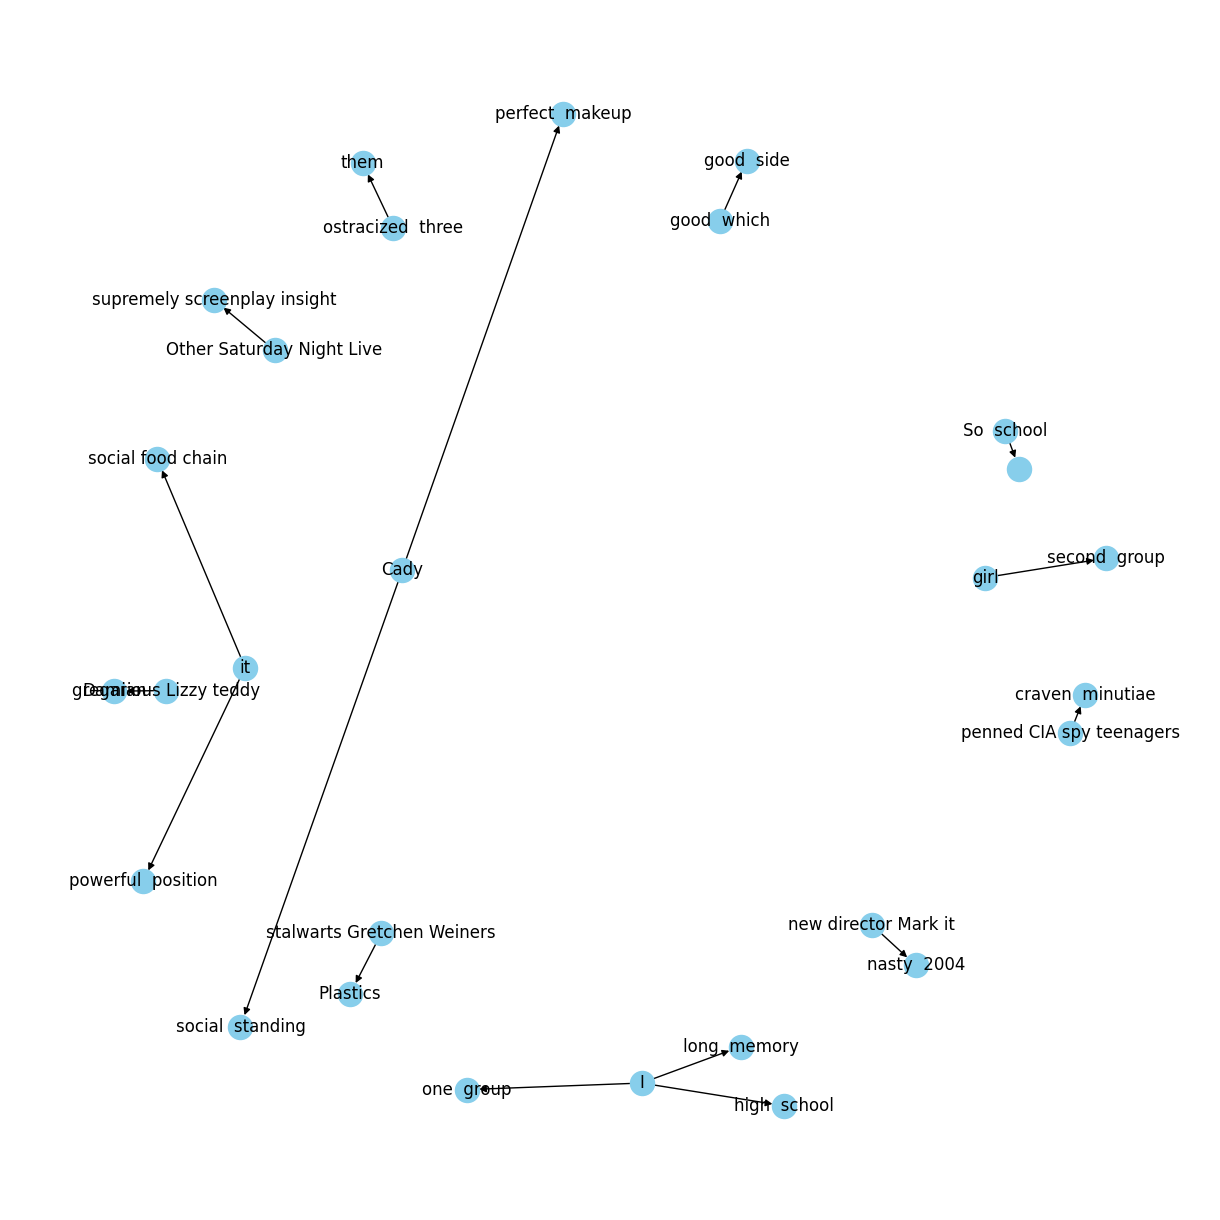

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True,
        node_color='skyblue',
        edge_cmap=plt.cm.Blues,
        pos=pos)

plt.savefig('G_1.png')


In [ ]:
movie_reviews


0    Although Mean Girls is likely to be frequently...
1    She is immediately befriended by two of North ...
2    Mean Girls '' is somewhat of a phenomenon in t...
3    The tagline for this movie - Watch Your Back -...
4    When 16-year-old Cady ( Lindsay Lohan ) first ...
5    `` In a wasteland of dumb movies about teenage...
6    Mean Girls looks and feels like a 2000s comedy...
7    Teenage Cady Heron ( Lindsay Lohan ) was educa...
8    Fans who found teen star Lindsay Lohan 's last...
9    'Gretchen , stop trying to make 'fetch ' happe...
Name: Text, dtype: object

In [ ]:
all_movie_reviews = ' '.join(movie_reviews)
doc = nlp(all_movie_reviews)
doc_sents = [str(x) for x in doc.sents]

In [ ]:
doc_sents[0]

"Although Mean Girls is likely to be frequently compared to Heathers , and perhaps occasionally to Election , the movie it most strongly reminds me of is 1999 's Jawbreaker ."

In [ ]:
doc_sents[-1]

"When school Queen Bee and leader of the Plastics , Regina George , takes a surprising interest in Cady , however , Janis , who 's clearly been bullied by"

In [ ]:
len(doc_sents)

175

In [ ]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 175/175 [00:01<00:00, 106.33it/s]


In [ ]:
relations = [get_relation(i) for i in tqdm(doc_sents)]
relations

100%|██████████| 175/175 [00:01<00:00, 101.34it/s]


['is',
 'offer',
 'is',
 'works for',
 'judged by',
 'have',
 'are',
 'dictates',
 'settle into',
 'means',
 'introduces',
 'getting',
 'is',
 'befriend',
 'is',
 'teach',
 'invited',
 'is',
 'finds',
 'catches',
 'decides',
 'appears',
 'strutting around',
 'managed',
 'is Mean',
 'crafted',
 'is',
 'missed',
 'tended',
 'make',
 'is',
 'resided within',
 'is',
 'rated',
 'are',
 'Written by',
 'raised',
 'gets',
 'seems',
 "'s",
 'befriends',
 'Janis',
 'warned about',
 'are',
 'is',
 'Watch',
 'been nasty',
 'crushed',
 'said',
 "'s",
 'is',
 'has',
 'become',
 'is despite',
 'been in',
 'is',
 'counterweighted with',
 'shown',
 'tastes like decaffeinated',
 'plays',
 'get',
 'is',
 'think',
 'goes out',
 'begins Mean',
 'Paramount',
 'Directed by',
 'Lohan',
 'VALUE',
 'SPECTATOR Much',
 'befriended by',
 'befriended by',
 'think',
 'is',
 'remain innocent',
 'swept into',
 'decides',
 "'s",
 'inspired by',
 'know',
 'contains',
 'filmed',
 'stars as',
 'is',
 'are',
 'makes',
 'in

In [ ]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()
kg_df.shape

(152, 3)

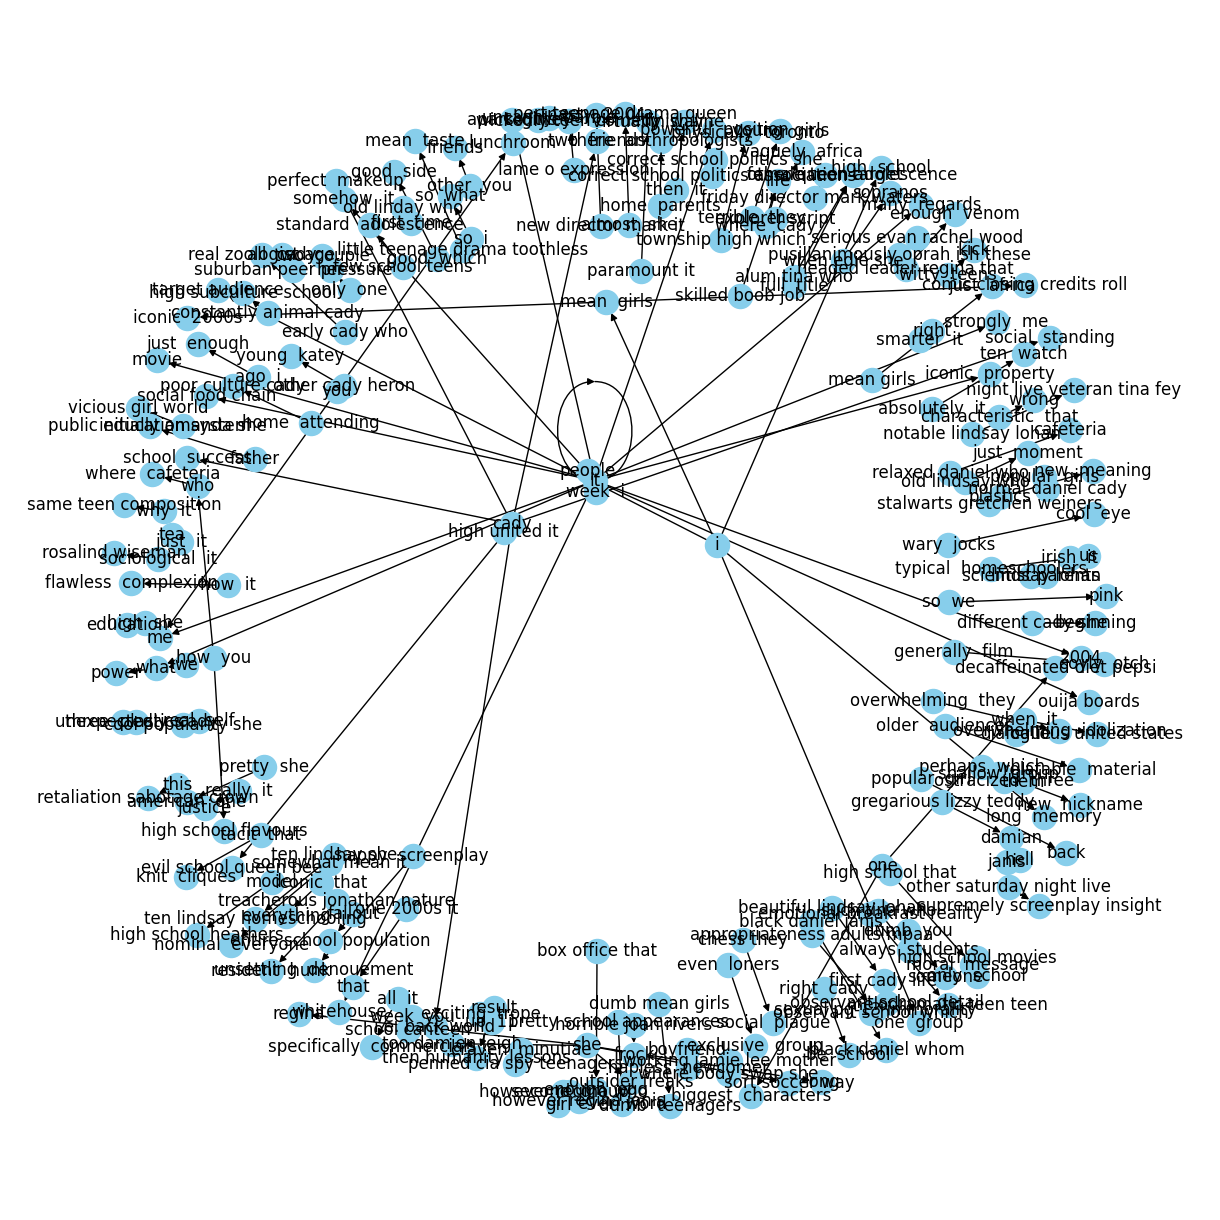

In [ ]:
G = nx.from_pandas_edgelist(kg_df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True,
        node_color='skyblue',
        edge_cmap=plt.cm.Blues,
        pos=pos)

plt.show()

In [ ]:
pd.Series(relations).value_counts()[:50]

is                 22
's                  9
are                 6
gets                3
know                2
think               2
plays               2
befriended by       2
decides             2
finds               2
invited             2
watched             2
do                  2
introduces          2
knew                2
Janis               2
be                  2
asked               1
caved               1
understood          1
get enough          1
look                1
heard               1
figured             1
'                   1
quoted Mean         1
educated in         1
called              1
sees                1
is terrific         1
going               1
dialled             1
is quirky           1
had                 1
seen Mean           1
is more             1
summarizes          1
dissects high       1
lies within         1
feels               1
be difficult        1
right               1
think of            1
give                1
one                 1
explain   

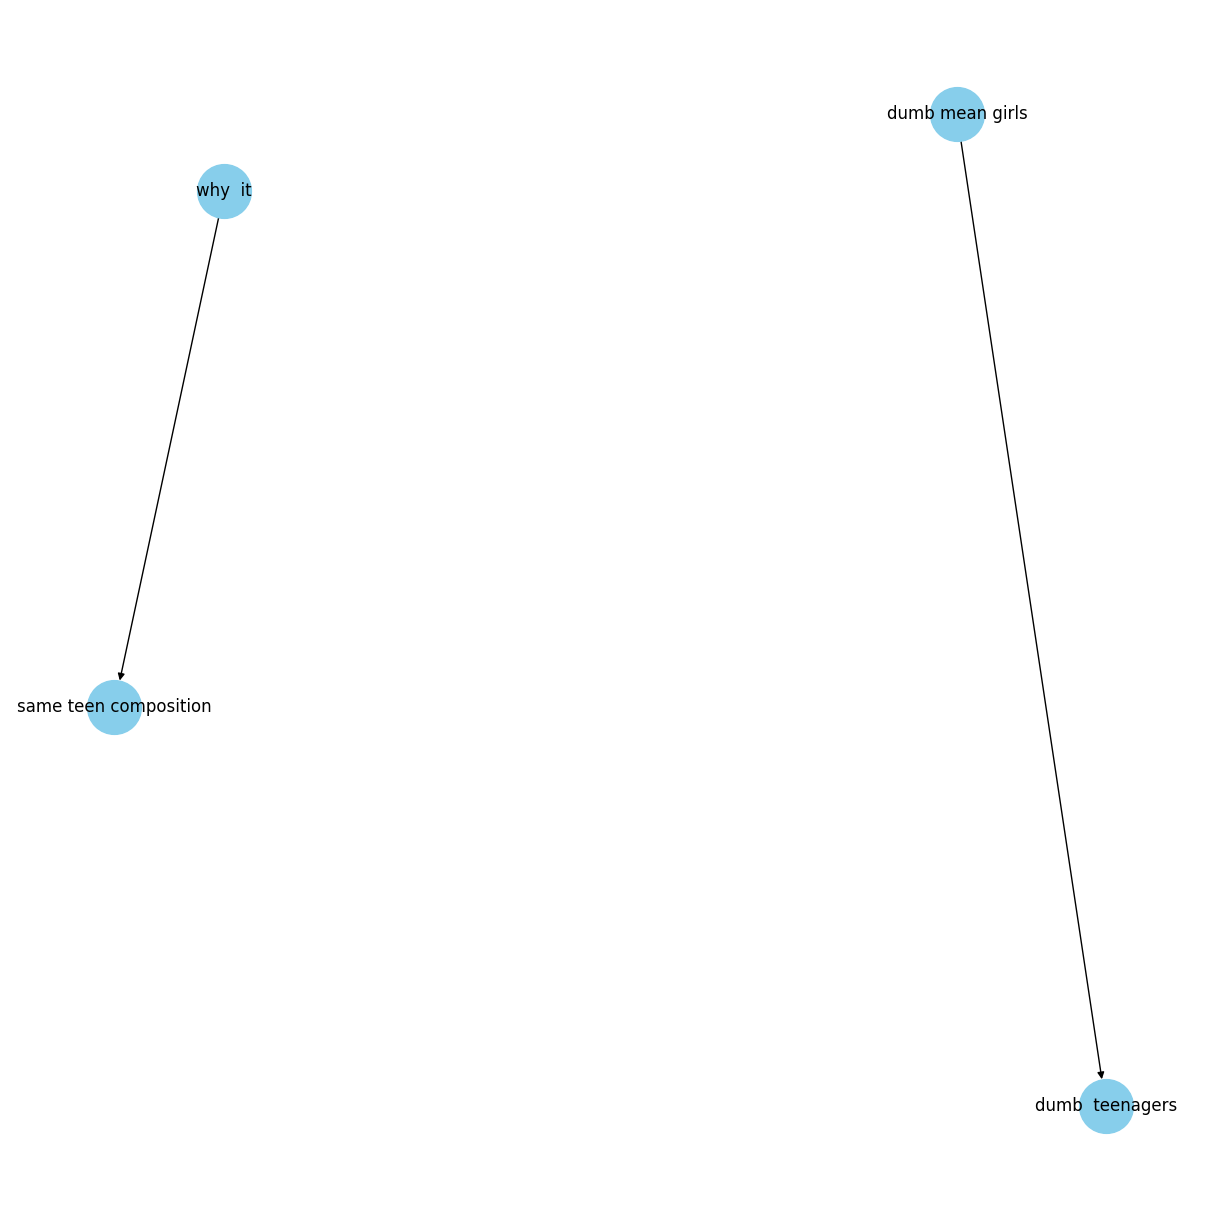

<Figure size 640x480 with 0 Axes>

In [ ]:
RELATION_TO_EXPLORE = 'know'
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='skyblue',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

plt.savefig('G_2.png')

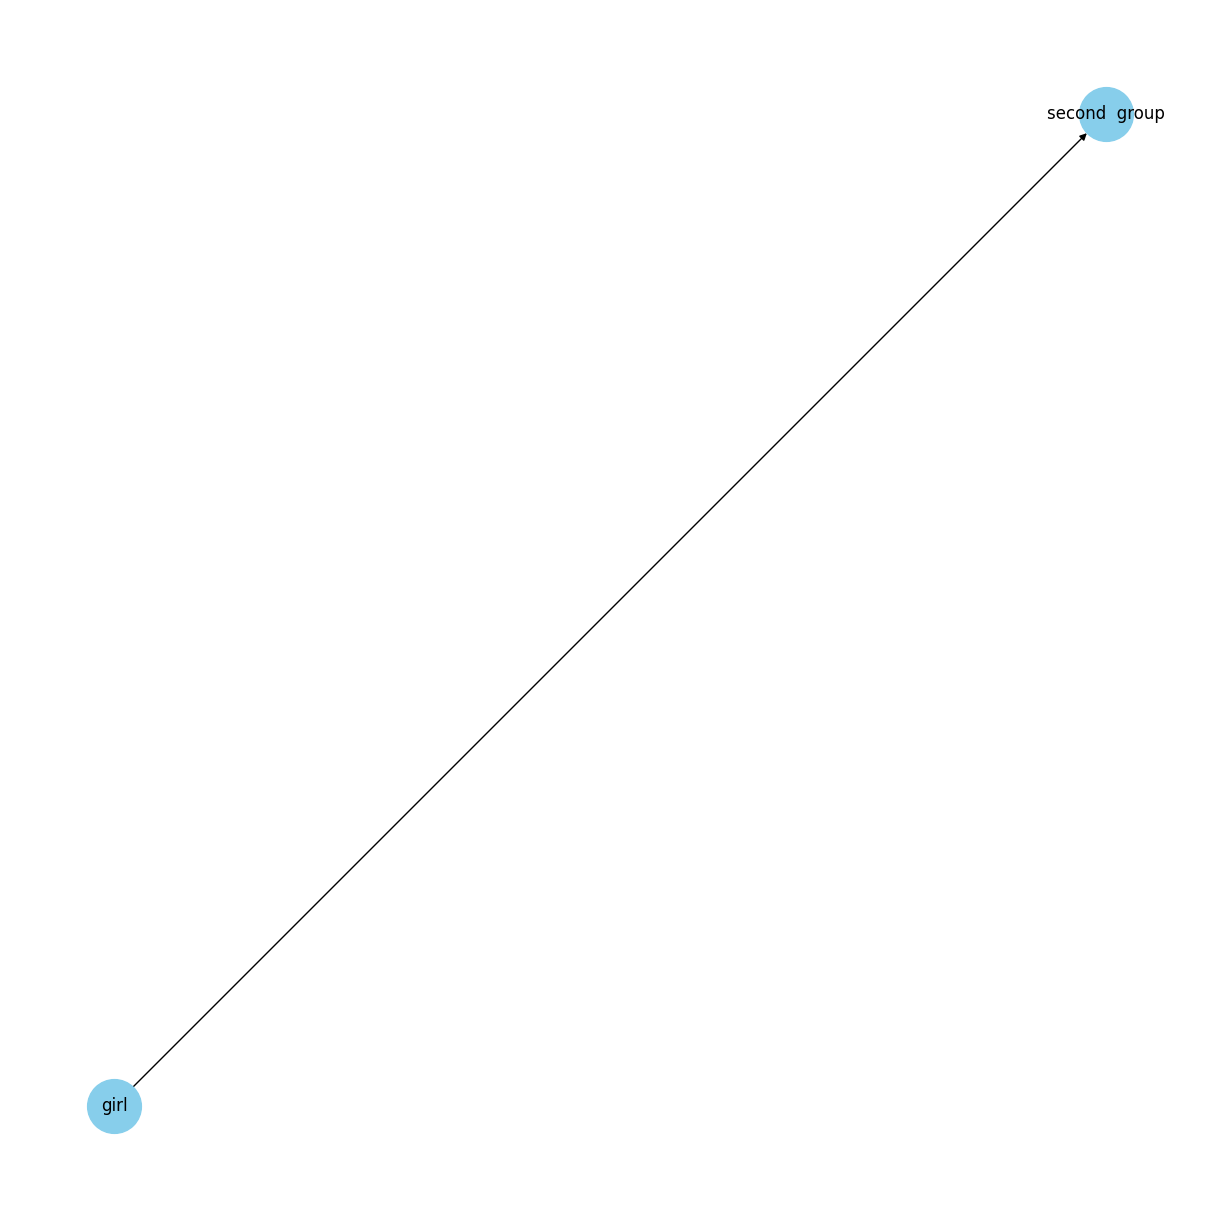

<Figure size 640x480 with 0 Axes>

In [ ]:
ENTITY_TO_EXPLORE = 'girl'
entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)
G = nx.from_pandas_edgelist(kg_df[entity_filter],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='skyblue',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()
plt.savefig('G_3.png')

# Part 2 LSTM

In [ ]:
movie_genre = data['Genre of Movie']

In [ ]:
data['Genre of Movie'].value_counts()

Action    50
Comedy    50
Horror    50
Sci-Fi    50
Name: Genre of Movie, dtype: int64

In [ ]:
data.columns

Index(['Text', 'Genre of Movie', 'Genre of Movie code'], dtype='object')

Model 1_1 : Genre

In [ ]:
from tensorflow.keras.layers import LSTM

model_1_1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    LSTM(64, return_sequences=True, dropout=0.3),
    LSTM(32, dropout=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_1_1.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [ ]:
%%time
history_1_1 = model_1_1.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 24s 294ms/step - loss: 1.3891 - accuracy: 0.1824 - val_loss: 1.3975 - val_accuracy: 0.0000e+00
Epoch 2/200
53/53 [==============================] - 13s 247ms/step - loss: 1.3886 - accuracy: 0.3019 - val_loss: 1.4366 - val_accuracy: 0.1111
Epoch 3/200
53/53 [==============================] - 13s 246ms/step - loss: 1.3966 - accuracy: 0.2264 - val_loss: 1.4331 - val_accuracy: 0.1111
Epoch 4/200
53/53 [==============================] - 13s 244ms/step - loss: 1.2901 - accuracy: 0.4277 - val_loss: 1.3270 - val_accuracy: 0.4444
Epoch 5/200
53/53 [==============================] - 13s 244ms/step - loss: 0.8514 - accuracy: 0.5660 - val_loss: 0.9680 - val_accuracy: 0.6667
Epoch 6/200
53/53 [==============================] - 13s 250ms/step - loss: 0.5510 - accuracy: 0.7862 - val_loss: 1.5886 - val_accuracy: 0.3333
Epoch 7/200
53/53 [==============================] - 13s 247ms/step - loss: 0.2486 - accuracy: 0.9434 - val_loss: 1.1709 - val_accur

In [ ]:
preds_1_1 = model_1_1.predict(test_ds)
y_pred_1_1 = np.argmax(preds_1_1, axis=1)
y_1_1= np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 3s 43ms/step


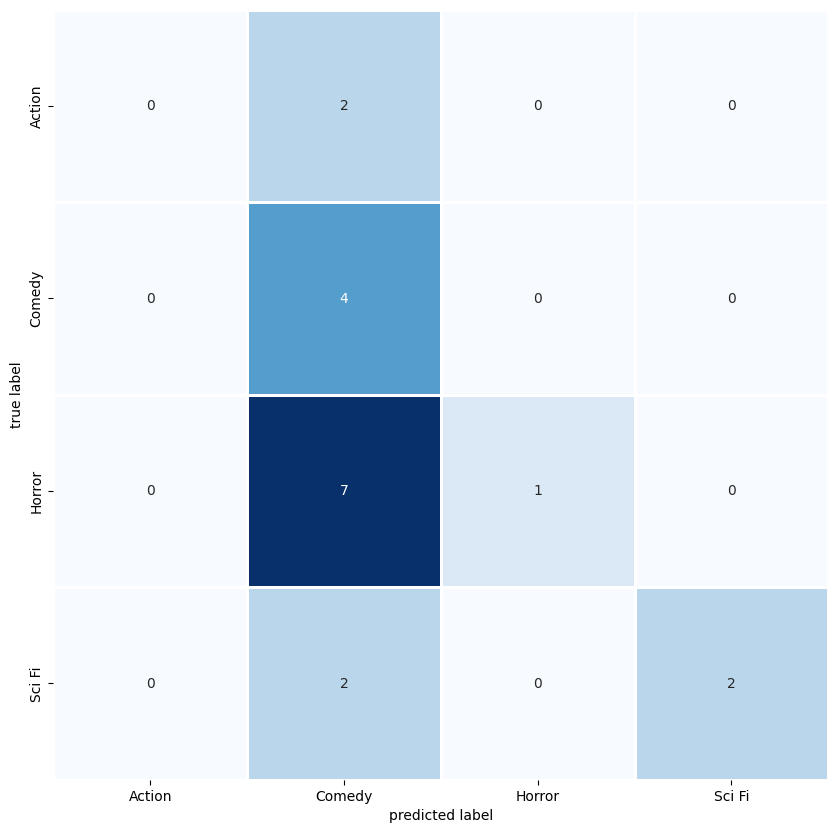

In [ ]:
plot_confusion_matrix_labeled(y_1_1,y_pred_1_1, CLASSES_LIST=CLASSES_LIST)

In [ ]:
df_1_1 = pd.DataFrame(preds_1_1[0:15]
                  ,columns = CLASSES_LIST).T
df_1_1.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,3.73%,0.29%,3.58%,2.48%,13.77%,3.55%,3.70%,0.54%,3.14%,34.00%,3.04%,3.02%,3.56%,6.69%,4.67%
Comedy,90.38%,0.36%,84.06%,84.51%,81.97%,85.08%,87.86%,9.24%,89.53%,64.35%,90.12%,52.91%,83.02%,88.62%,87.64%
Horror,5.50%,1.21%,11.57%,12.50%,3.72%,10.64%,7.90%,89.35%,6.92%,1.46%,6.48%,42.51%,12.58%,4.20%,7.06%
Sci Fi,0.40%,98.14%,0.80%,0.51%,0.54%,0.73%,0.55%,0.87%,0.41%,0.20%,0.36%,1.56%,0.85%,0.49%,0.63%


Model 2: Genre

In [ ]:
from tensorflow.keras.layers import LSTM

model_1_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    LSTM(32, return_sequences=True, dropout=0.3),
    LSTM(16, dropout=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_1_2.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [ ]:
history_1_2 = model_1_2.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 24s 282ms/step - loss: 1.3879 - accuracy: 0.2075 - val_loss: 1.3788 - val_accuracy: 0.4444
Epoch 2/200
53/53 [==============================] - 12s 229ms/step - loss: 1.3001 - accuracy: 0.3082 - val_loss: 1.2261 - val_accuracy: 0.5556
Epoch 3/200
53/53 [==============================] - 12s 228ms/step - loss: 0.9354 - accuracy: 0.4843 - val_loss: 1.1103 - val_accuracy: 0.3333
Epoch 4/200
53/53 [==============================] - 12s 228ms/step - loss: 0.8687 - accuracy: 0.4906 - val_loss: 1.1093 - val_accuracy: 0.4444


In [ ]:
preds_1_2 = model_1_2.predict(test_ds)
y_pred_1_2 = np.argmax(preds_1_2, axis=1)
y_1_2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 11s 38ms/step


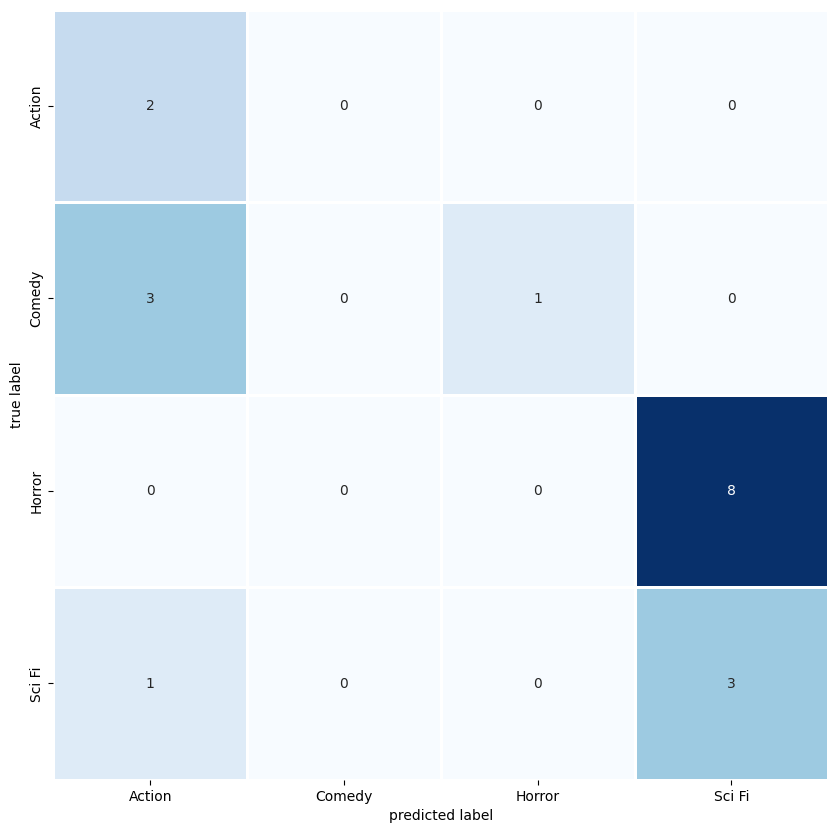

In [ ]:
plot_confusion_matrix_labeled(y_1_2,y_pred_1_2, CLASSES_LIST=CLASSES_LIST)

In [ ]:
df_1_2 = pd.DataFrame(preds_1_1[0:15]
                  ,columns = CLASSES_LIST).T
df_1_2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,3.73%,0.29%,3.58%,2.48%,13.77%,3.55%,3.70%,0.54%,3.14%,34.00%,3.04%,3.02%,3.56%,6.69%,4.67%
Comedy,90.38%,0.36%,84.06%,84.51%,81.97%,85.08%,87.86%,9.24%,89.53%,64.35%,90.12%,52.91%,83.02%,88.62%,87.64%
Horror,5.50%,1.21%,11.57%,12.50%,3.72%,10.64%,7.90%,89.35%,6.92%,1.46%,6.48%,42.51%,12.58%,4.20%,7.06%
Sci Fi,0.40%,98.14%,0.80%,0.51%,0.54%,0.73%,0.55%,0.87%,0.41%,0.20%,0.36%,1.56%,0.85%,0.49%,0.63%


Model 3: Genre

In [ ]:
model_1_3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),  # Increase LSTM units
    LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),  # Increase LSTM units
    LSTM(16, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),  # Increase LSTM units
    LSTM(8, dropout=0.3, recurrent_dropout=0.2),  # Increase LSTM units
    tf.keras.layers.Dense(128, activation='relu'),  # Add more dense layers
    tf.keras.layers.Dense(64, activation='relu'),  # Add more dense layers
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_1_3.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [ ]:
history_1_3 = model_1_3.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

In [ ]:
preds_1_3 = model_1_3.predict(test_ds)
y_pred_1_3 = np.argmax(preds_1_3, axis=1)
y_1_3 = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
plot_confusion_matrix_labeled(y_1_3,y_pred_1_3, CLASSES_LIST=CLASSES_LIST)

In [ ]:
df_1_3 = pd.DataFrame(preds_1_3[0:15]
                  ,columns = CLASSES_LIST).T
df_1_3.style.format("{:.2%}").background_gradient(cmap=cm)

In [ ]:
#part 2

In [ ]:
from pathlib import Path
from sys import path
from google.colab import drive
import os


drive.mount('/content/gdrive')


root_examples_dir = Path('/Users/Nora/Desktop')
root_examples_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
pos_examples_dir = root_examples_dir / 'pos'
neg_examples_dir = root_examples_dir / 'neg'
pos_examples_dir.mkdir(parents=True, exist_ok=True)
neg_examples_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
class_corpus_pos = corpus_df.loc[corpus_df["Review Type (pos or neg)"] == 'Positive', 'Text']
class_corpus_neg = corpus_df.loc[corpus_df["Review Type (pos or neg)"] == 'Negative', 'Text']

In [ ]:
class_corpus_pos.shape, class_corpus_neg.shape


In [ ]:
for review_index, review in zip(class_corpus_pos.index, class_corpus_pos):
    with open(pos_examples_dir / (str(review_index) + ".txt"), "w") as f:
        f.write(review)
for review_index, review in zip(class_corpus_neg.index, class_corpus_neg):
    with open(neg_examples_dir / (str(review_index) + ".txt"), "w") as f:
        f.write(review)
len(list(pos_examples_dir.glob("*.txt"))), len(list(neg_examples_dir.glob("*.txt")))

In [ ]:
BATCH_SIZE = 3
raw_train_ds = tf.keras.utils.text_dataset_from_directory(root_examples_dir,
                                                          batch_size=BATCH_SIZE,
                                                          validation_split=0.2,
                                                          subset='training',
                                                          seed=20130810)

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(root_examples_dir,
                                                        batch_size=BATCH_SIZE,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        seed=20130810)

In [ ]:

train_ds = (raw_train_ds.shuffle(buffer_size=raw_train_ds.cardinality().numpy())
                        .cache()
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

val_ds = (raw_val_ds.shuffle(buffer_size=raw_train_ds.cardinality().numpy())
                    .cache()
                    .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            standardize="lower_and_strip_punctuation",
                                            pad_to_max_tokens=True)

In [ ]:

encoder.adapt(train_ds.map(lambda text, label: text),
              batch_size= None)
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

In [ ]:

print("1340: ", encoder.get_vocabulary()[1340])
print("1: ", encoder.get_vocabulary()[1])

print(f'Vocabulary size: {len(encoder.get_vocabulary())}')

Model 1: sentiment

In [ ]:
NUM_CLASSES = 2
model_2_1 = tf.keras.Sequential([# encoder generates one hot encoded corpus based on the vocabulary
                             encoder,
                             # Embedding layer projects this vocabulary down to a smaller dimension
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()),
                                                       64,
                                                       mask_zero=True),
                             # The first LSTM layer uses the outputs from the embedding layer
                             # as the input sequence
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                                                                return_sequences=True,
                                                                                dropout=0.3)),
                             # The second LSTM layer uses the outputs from the first LSTM
                             # layer as the input sequence
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                                                dropout=0.3)),
                             # The Dense layer uses outputs from the last time step of
                             # the LSTM layer
                             tf.keras.layers.Dense(64, activation='relu'),
                             # The final layer outputs the
                             tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [ ]:
model_2_1.summary()

In [ ]:
model_2_1.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history_2_1 = model_2_1.fit(train_ds,
                    epochs=200,
                    validation_data=val_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=5)])

Model 2: sentiment

In [ ]:
NUM_CLASSES = 2
model_2_2 = tf.keras.Sequential([# encoder generates one hot encoded corpus based on the vocabulary
                             encoder,
                             # Embedding layer projects this vocabulary down to a smaller dimension
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()),
                                                       64,
                                                       mask_zero=True),
                             # The first LSTM layer uses the outputs from the embedding layer
                             # as the input sequence
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, #changed from 64 layers
                                                                                return_sequences=True,
                                                                                dropout=0.3)),
                             # The second LSTM layer uses the outputs from the first LSTM
                             # layer as the input sequence
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                                                dropout=0.3)),
                             # The Dense layer uses outputs from the last time step of
                             # the LSTM layer
                             tf.keras.layers.Dense(32, activation='relu'),
                             # The final layer outputs the
                             tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model_2_2.summary()

In [ ]:
model_2_2.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history_2_2 = model_2_2.fit(train_ds,
                    epochs=200,
                    validation_data=val_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=5)])

Model 3: sentiment

In [ ]:
model_2_3 = tf.keras.Sequential([
    encoder,  # The TextVectorization layer
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3),  # Single LSTM layer with 64 units
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3),  # Additional LSTM layer with 64 units
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),  # TimeDistributed Dense layer
    tf.keras.layers.GlobalAveragePooling1D(),  # Global average pooling
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])


In [ ]:
model_2_3.summary()

In [ ]:
model_2_3.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history_2_3 = model_2_2.fit(train_ds,
                    epochs=200,
                    validation_data=val_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=5)])

In [ ]:
%%shell
jupyter nbconvert --to html /content/A_3.ipynb